In [1]:
import numpy as np
from scipy.optimize import curve_fit
from PIL import Image, ImageOps
from eidynamics import generate_camera_image
from eidynamics import pattern_index

In [2]:
import pathlib
import importlib

In [6]:
bfi = pathlib.Path(r"C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figure_matter\192_slice1_4x_IR.bmp")
fli = pathlib.Path(r"C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\paper_figure_matter\192_slice1_4x_tdTom.bmp")

In [8]:
importlib.reload(generate_camera_image)
im = generate_camera_image.main(bfi,fluor_file=fli)
im.show()

1435 1024


In [9]:
class Frame():
    def __init__(self, offset, channel='tdTomato'):
        self.LUT = {'tdTomato':(255,174,127,255),
                    'eYFP'   :(234,255,127,255),
                    'GFP'    :(127,255,127,255),
                    'IR'     :(200,200,200,255),
                    'grey'   :(200,200,200,255)}

        self.channel=channel
        self.channel_color = self.LUT[channel][:3]
        self.offset = offset
        self.mode   = ''
        self.alpha  = 1.0
        self.mask   = []

    def set_image(self,image):
        self.image  = image
        self.size   = self.image.size
        self.height,self.width = self.size
        self.mode   = self.image.mode

    def add_layer(self,new_layer_image,ofx,ofy):
        im1 = self.image
        im2 = new_layer_image
        # ofx = frameObj.offset[0]
        # ofy = frameObj.offset[1]
        new_image = im1.paste(im2,(ofx,ofy),mask=im2)
        return new_image

    def make_background_transparent(self,input_image,background_color=(0,0,0)):
        image = input_image.convert('RGBA')
        bgR,bgG,bgB = background_color
        # Transparency
        newImage = []
        for item in image.getdata():
            if item[:3] == background_color:
                new_color = (bgR,bgG,bgB,0)
                newImage.append(new_color)
            else:
                newImage.append(item)

        image.putdata(newImage)

        return image

    def apply_LUT(self,channel_color):
        im1 = self.image.convert('L')
        im2 = ImageOps.colorize(im1,black=(0,0,0),white=(255,255,255),mid=channel_color)
        return im2

    def set_mask():
        pass


In [10]:
imageFile = r"C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\testExamples\slice_tdTom.bmp"

In [11]:
def pixel_scaling(x,m,c):
    y = m*np.array(x) + c
    return y

def calculate_offset(x=[0.25,0.5,0.75],y=[0.25,0.5,0.75],cx=[285,642,1002],cy=[341,535,730]):
    '''
    Data from 24 Dec 2021 Calibration
        Polygon Frame Fraction		Camera Pixel Number	
		x	    y	                cx	    cy
		0.25	0.25	            285	    341
		0.5	    0.5	                642	    535
		0.75	0.75	            1002	730
		0.125	0.125	            106	    244
		0.625	0.25	            822	    632
		0.375	0.375	            464	    439
		0.875	0.875	            1183	827
    '''
    poptx,_              = curve_fit(pixel_scaling,x,cx)
    popty,_              = curve_fit(pixel_scaling,y,cy)

    x0,y0 = [pixel_scaling(0,*poptx), pixel_scaling(0,*popty)]
    x1,y1 = [pixel_scaling(1,*poptx), pixel_scaling(1,*popty)]

    polygon_frame_properties =  {   
                                'top_left'      :[x0,y0],
                                'top_right'     :[x1,y0],
                                'bottom_right'  :[x0,y1],
                                'bottom_left'   :[x1,y1],
                                'width'         : x1-x0,
                                'height'        : y1-y0,
                                'aspect_ratio'  :(x1-x0) / (y1-y0),
                                'scaling'       :[round((x1-x0)/24), round((y1-y0)/24)],
                                'offsetx'       : int(x0),
                                'offsety'       : int(y0),
                                }

    return polygon_frame_properties

In [12]:
def draw_polygon_frame(sqSet=[],grid_size=24,draw_grid=True):
    pixels = np.zeros((grid_size*grid_size,1))
    pixels[sqSet] = 1
    frameArray = np.reshape(pixels,(grid_size,grid_size))
    frameImage = Image.fromarray(frameArray*255).convert('RGBA')

    frame_properties = calculate_offset()
    scaling = frame_properties['scaling']
    frameLarge = frameImage.resize(np.multiply(frameImage.size,scaling),0)

    if draw_grid:
        grid = np.zeros(frameLarge.size).T
        grid[:,::scaling[0]] = 1
        grid[::scaling[1],:] = 1
        gridImage = Image.fromarray(grid*255).convert('RGBA')

        polygon_frame_image = Image.blend(frameLarge,gridImage,0.3)
    else:
        polygon_frame_image = frameLarge

    output_image = replace_color_with_transparency(polygon_frame_image)

    return output_image,frame_properties


In [13]:
def replace_color_with_transparency(input_image,remove_color=(0,0,0)):
    image = input_image.convert('RGBA')

    # Transparency
    newImage = []
    for item in image.getdata():
        if item[:3] == remove_color:
            new_color = (remove_color[0],remove_color[1],remove_color[2],0)
            newImage.append(new_color)
        else:
            newImage.append(item)

    image.putdata(newImage)

    return image
    

In [14]:
camframe = Frame(offset=[0,0],channel='IR')

In [15]:
camfile = "C:\\Users\\user\\OneDrive\\NCBS\\Lab\\Projects\\EI_Dynamics\\Data\\21-12-31_G620\\6201_CA3.bmp"

In [16]:
# with Image.open(camfile,'r') as c:
camImage = Image.open(camfile)
camframe.set_image(camImage)

In [17]:
polyImage,polyImProp = draw_polygon_frame(sqSet=pattern_index.patternID[999])

In [18]:
polyframe = Frame(offset=[polyImProp['offsetx'],polyImProp['offsety']],channel='GFP')

In [19]:
polyframe.set_image(polyImage)
# newImage = polyframe.apply_LUT(polyframe.channel_color)

In [20]:
newImage = polyframe.apply_LUT(polyframe.channel_color)

In [21]:
newImage2 = polyframe.make_background_transparent(newImage)

In [22]:
image3 = camframe.add_layer(newImage2,polyframe.offset[0],polyframe.offset[1])

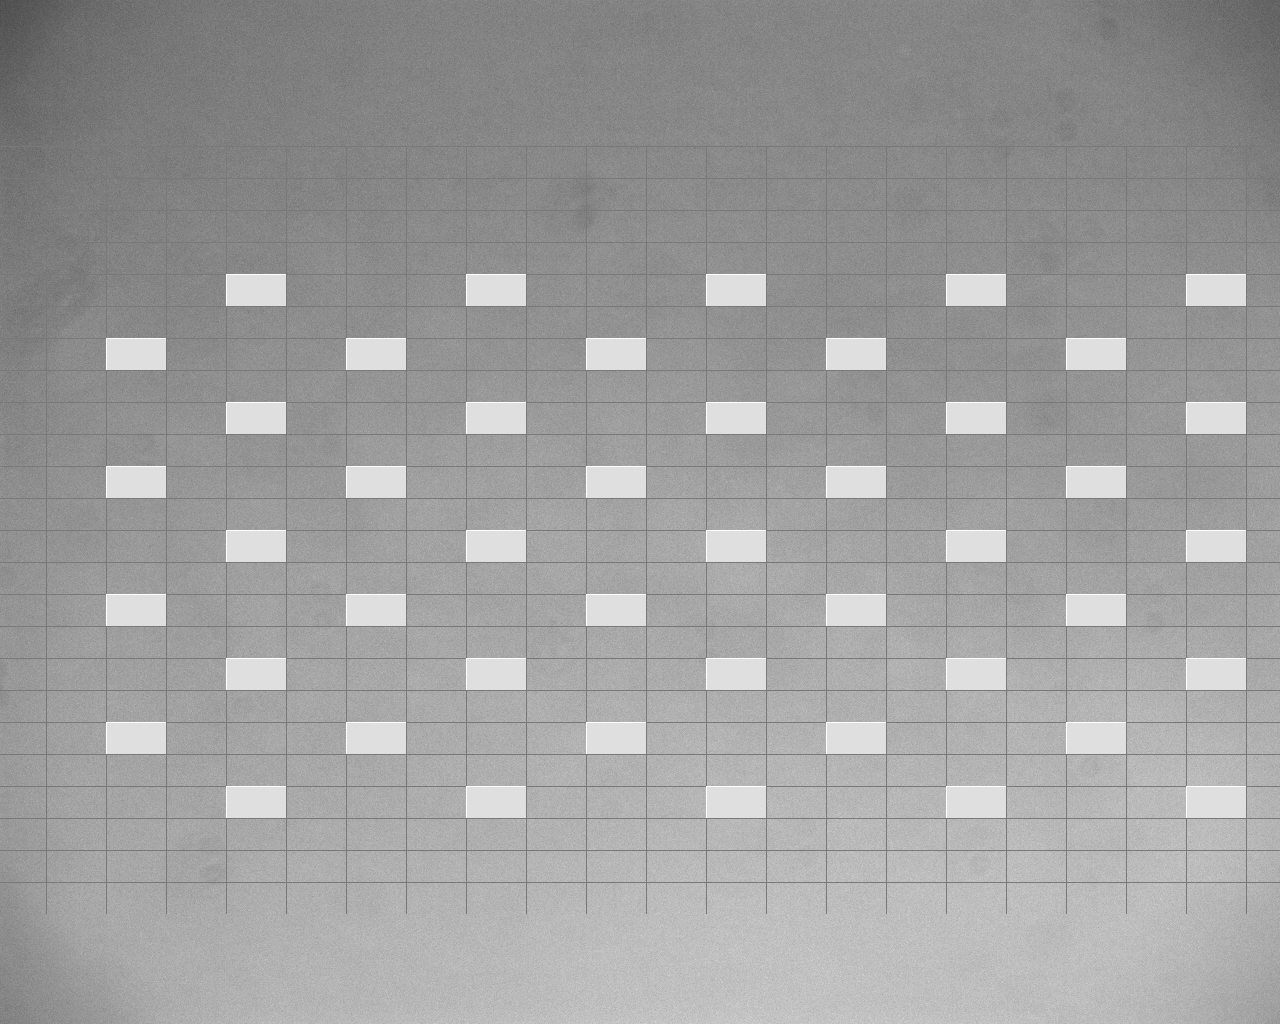

In [23]:
camframe.image

In [24]:
def add_offset(input_image, left, top, right, bottom, color=(0,0,0)):
    width, height = input_image.size
    new_width = width + right + left
    new_height = height + top + bottom
    canvas = Image.new(input_image.mode, (new_width, new_height), color)
    canvas.paste(input_image, (left, top))
    return canvas

In [25]:
im1 = camImage.copy().convert('RGBA')
maask = newImage2.getchannel('A')
im1.paste(newImage2,(-75,146),mask=newImage2)

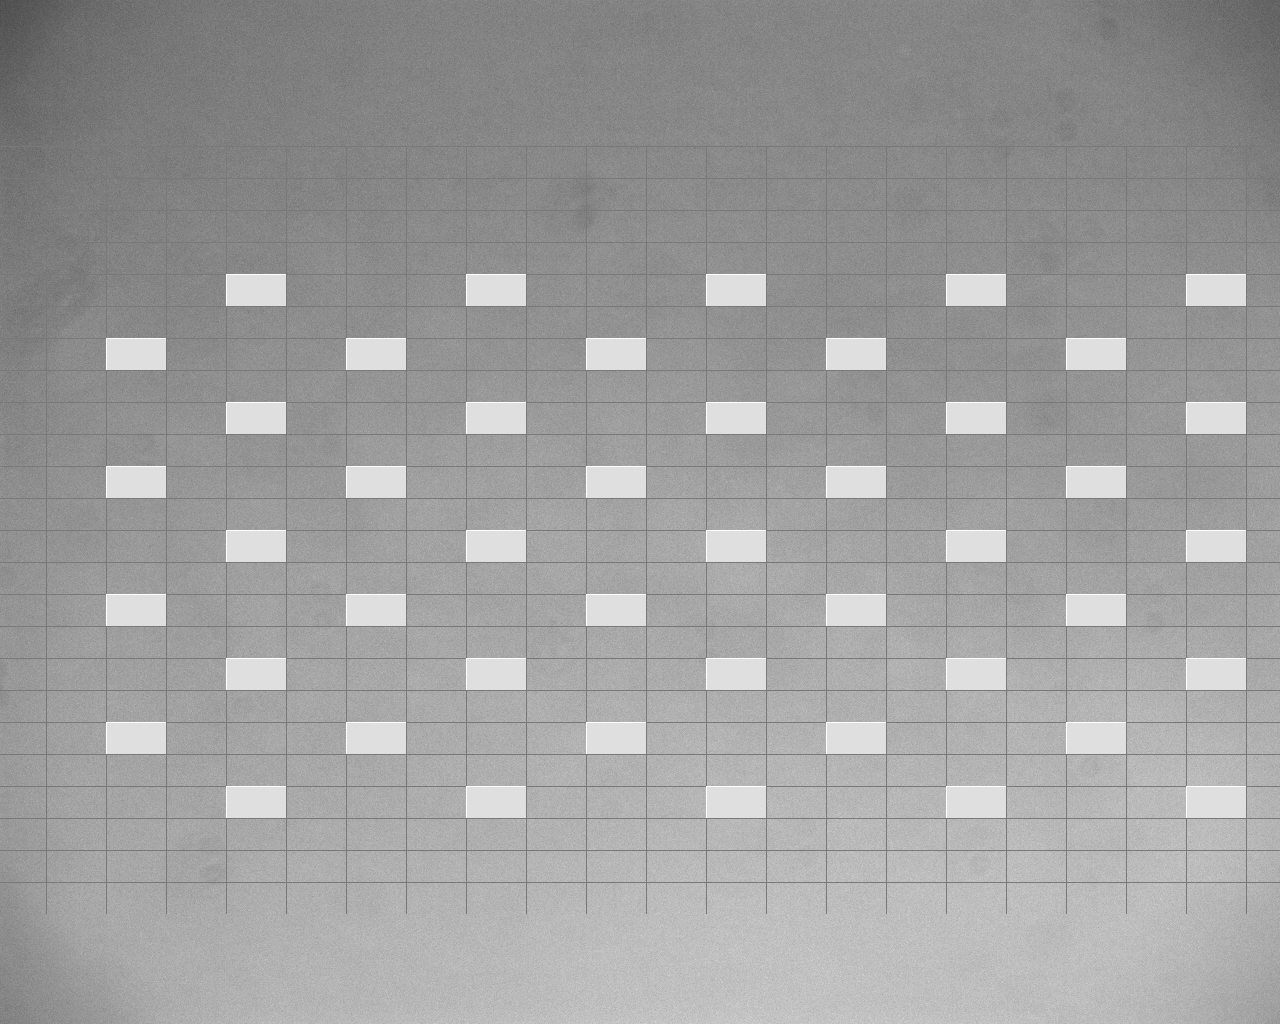

In [26]:
camImage

### Code to change file names of camera images

In [102]:
# check if a string contains '4x' or '40x'
import re
def check_mag(filename):
    mag = re.findall(r'\d+x',filename)
    if mag:
        return mag[0]
    else:
        im = Image.open(filepath)
        mag = input('Enter magnification: ')
        return mag



In [195]:
def file_rename(file_fullpath):
    file_fullpath = pathlib.Path(file_fullpath)
    filename   = pathlib.Path(file_fullpath).name
    parent_dir = pathlib.Path(file_fullpath).parent

    # check if file_fullpath contains slice number
    if 'slice' in str(file_fullpath).lower():
        slice_mention = re.findall(r'slice\d+', str(file_fullpath).lower())
        slice_num = (slice_mention[0] + '_') if slice_mention else ''
    else:
        slice_num = ''

    # get cellID
    cellID = ''
    cell_num_in_filename = re.findall(r'cell+\d', file_fullpath.stem)

    if parent_dir.name.isdigit():
        cellID = parent_dir.name + '_'
    elif cell_num_in_filename:
        cellnum = cell_num_in_filename[0][-1]
        animalID = parent_dir.name[-3:]
        cellID = animalID + cellnum + '_'
    else:
        raise ValueError('Cell ID not found in filename or parent directory name')
        cellID = input('Enter cell ID: ') + '_'

    # get magnification
    mag_mention = re.findall(r'\d+x', filename)
    if mag_mention:
        mag = mag_mention[0] + '_'
    else:
        im  = Image.open(file_fullpath)
        raise ValueError('Magnification not found in filename')
        mag = input('Enter magnification: ') + 'x_'

    # check if filename contains 'tdTom' or 'IR'
    chs = []
    if 'tdtom' in filename.lower():
        chs = ['tdTom']
    if 'IR' in filename:
        chs.append('IR')
    chname = ('-'.join(chs)+'_') if chs else ''
    

    # location
    locs = []
    if 'CA3' in filename:
        locs.append('CA3')
    if 'CA1' in filename:
        locs.append('CA1')
    locs = ('-'.join(locs)+'_') if locs else ''

    # make new file name
    # print(slice_num , cellID , mag , locs , chname)
    new_file_name = slice_num + cellID + mag + locs + chname + '.bmp'

    return new_file_name


In [206]:
# get all '.bmp' files in a directory tree

def get_files_in_dir_tree(dir_path, file_type='.bmp'):
    file_list = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith(file_type):
                file_list.append(os.path.join(root, file))
    return file_list

In [189]:
import os

In [207]:
infiles = get_files_in_dir_tree(r"C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data")

In [213]:
outfiles = []
skippedfiles = []

for file in infiles:

    try:
        new_file_name = file_rename(file)
        print('file xxxxxxx to: ', file)
        print('file renamed to: ', new_file_name, '\n')
    except ValueError:
        skippedfiles.append(file)
        continue
    
    
    # print(file, new_file_name)
    outfiles.append(new_file_name)
    im = Image.open(file)
    im.save(new_file_name)
    im.close()

file xxxxxxx to:  C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\20-01-11_864\slice2_cell1_40x_stimFiled.bmp
file renamed to:  slice2_8641_40x_.bmp 

file xxxxxxx to:  C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\20-02-05_G88\cell1_CA3field_40x.bmp
file renamed to:  G881_40x_CA3_.bmp 

file xxxxxxx to:  C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\22-01-17_G628\6282\slice3_cell6282_CA3_tdTom+IR_40xWI.bmp
file renamed to:  slice3_6282_40x_CA3_tdTom-IR_.bmp 

file xxxxxxx to:  C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\22-01-17_G628\6282\slice3_cell6282_CA3_tdTom+IR_4x.bmp
file renamed to:  slice3_6282_4x_CA3_tdTom-IR_.bmp 

file xxxxxxx to:  C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\22-01-17_G628\6282\slice3_cell6282_CA3_tdTom+IR_4x_correctplacement.bmp
file renamed to:  slice3_6282_4x_CA3_tdTom-IR_.bmp 

file xxxxxxx to:  C:\Users\user\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\22-01-17_G628\6282\slice3_cell6282_CA3_t

In [209]:
outfiles

['slice2_8641_40x_.bmp',
 'G881_40x_CA3_.bmp',
 'slice3_6282_40x_CA3_tdTom-IR_.bmp',
 'slice3_6282_4x_CA3_tdTom-IR_.bmp',
 'slice3_6282_4x_CA3_tdTom-IR_.bmp',
 'slice3_6282_4x_CA3_tdTom_.bmp',
 'slice1_6461_4x_tdTom-IR_.bmp',
 '7492_4x_.bmp',
 '7492_4x_.bmp',
 '7492_4x_tdTom_.bmp',
 '7492_4x_tdTom_.bmp',
 '7492_4x_tdTom_.bmp',
 '0111_4x_.bmp',
 '0111_4x_tdTom_.bmp',
 '0111_40x_CA3_tdTom_.bmp',
 '1981_40x_CA3_.bmp',
 '1981_4x_CA3_.bmp',
 '1981_4x_CA3_tdTom_.bmp',
 '1981_4x_CA3_tdTom_.bmp',
 '2651_4x_IR_.bmp',
 '2651_4x_.bmp',
 '2651_40x_CA3_IR_.bmp',
 '2651_4x_tdTom-IR_.bmp',
 '2651_4x_tdTom_.bmp',
 'slice2_2601_40x_tdTom-IR_.bmp',
 'slice2_2601_4x_.bmp']

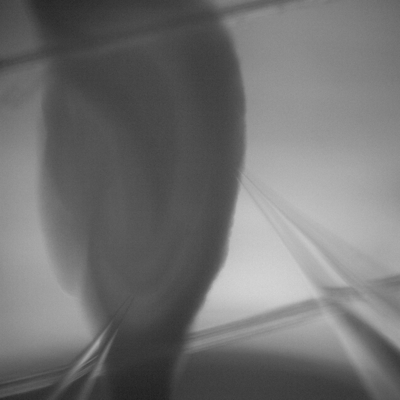

In [92]:
# show image inline, small size

from IPython.display import display, clear_output
from PIL import Image

for file in files:
    im = Image.open(file)
    # reset display
    clear_output(wait=True)
    # display image
    display(im.resize((400,400)))